In [1]:
import torch
import pandas as pd
import numpy as np
import pickle, logging, spacy, sys, os, json, requests
import matplotlib.pyplot as plt

from helpers.classes import Collection
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import datetime

In [2]:
from helpers.cloze_generation import generate_clozes_from_point, named_entity_answer_generator as ne_answer_generator, noun_phrase_answer_generator as np_answer_generator

from helpers.table_processing import preprocess_table, read_process_table, find_relevant_column_header, find_relevant_content
from helpers.t5_language_model import summarise_t5_results


# df = pd.read_pickle('pickles/dataset_20210625_184837.pkl')
# clozes_df = pd.read_json('pickles/clozes_20210807_165700.json')

df = pd.read_pickle('pickles/collection_20210624_194932.pkl')
# clozes_df = pd.read_json('pickles/clozes_20210824.json')
clozes_df = pd.read_json('pickles/clozes_with_false_20210825.json') #contains negs

In [3]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('fivethirtyeight')

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [6]:
clozes_df

,cloze_text,source_text,true,false,answer_text,answer_type,answer_length,ids,bulletin,data
0,"In TEMPORALMASK, approximate gross value added...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In the years 2013 to 2017, approximate gross v...",2019,DATE,1,ccf75a2c157eacc5253f0e8a55b1ded9f5386d58,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...
1,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","£1,313.9 billion",MONEY,2,fc3346f2545ca5059bdb5150b998300c5001bea5,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...
2,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",£42.8 billion,MONEY,2,81aa32270d547a368e7b806646c72069ba4fac43,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...
3,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",3.4%,PERCENT,1,f308eb661ad1d6c8021cf9e22d8e8c7d9c5ff50e,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...
4,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",2018,DATE,1,0a0bcf4b990f1926bc87fa662badadaf7e23d5fa,businessindustryandtrade/business/businessserv...,[/businessindustryandtrade/business/businessse...
...,...,...,...,...,...,...,...,...,...,...
6179,Around 6 in 10 people (61%) reported feeling s...,Around 6 in 10 people (61%) reported feeling s...,Around 6 in 10 people (61%) reported feeling s...,Around 6 in 10 people (61%) reported feeling s...,76%,PERCENT,1,dce8c5e1d183452a3cc887d90ff0f64ef4bb82b5,peoplepopulationandcommunity/wellbeing/article...,[/peoplepopulationandcommunity/wellbeing/datas...
6180,"In comparison, NUMERICMASK of people did not f...","In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...","In comparison, 46.6% of people did not feel si...",around 14%,PERCENT,2,e7c1fce9fcd8c918a07029ba4266c18391b1aa75,peoplepopulationandcommunity/wellbeing/article...,[/peoplepopulationandcommunity/wellbeing/datas...
6181,"In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...",38%,PERCENT,1,874948014cfa36eff9f493b57e8077f3bda23019,peoplepopulationandcommunity/wellbeing/article...,[/peoplepopulationandcommunity/wellbeing/datas...
6182,Some of the main UK findings (Source: IDENTITY...,Some of the main UK findings (Source: Understa...,Some of the main UK findings (Source: Understa...,Some of the main UK findings (Source: NHS Isle...,Understanding Society,ORG,2,fab3e03bd458df568f3d110940583bc1251dfd90,peoplepopulationandcommunity/wellbeing/article...,[/peoplepopulationandcommunity/wellbeing/datas...


In [ ]:
unique_bulletins_reldata = clozes_df[['bulletin', 'data']]
unique_bulletins_reldata = unique_bulletins_reldata.loc[unique_bulletins_reldata.astype(str).drop_duplicates().index]


datalookup = dict()
for _, row in unique_bulletins_reldata.iterrows():
    bulletin = row.bulletin
    reldata = row.data
    for data in reldata:
        current = datalookup.get(data, set())
        current.add(bulletin)
        datalookup[data] = current


num_of_bulletins_per_dataset = []
for k in datalookup:
    num_of_bulletins_per_dataset.append(len(datalookup.get(k)))

In [166]:
print(f'number of bulletins: {clozes_df.bulletin.nunique()}')
print(f'number of unique cloze_text: {clozes_df.cloze_text.nunique()}')
print(f'average number of datasets per bulletin: {clozes_df.data.apply(lambda x: len(x)).values.mean()} ({clozes_df.data.apply(lambda x: len(x)).values.std()})')
print(f"average number of words per cloze: {clozes_df.source_text.apply(lambda x: len(x.split(' '))).values.mean()} ({clozes_df.source_text.apply(lambda x: len(x.split(' '))).values.std()})")
print(f"average extracted sentences per bulletin: {clozes_df.groupby('bulletin').source_text.nunique().values.mean()} ({clozes_df.groupby('bulletin').source_text.nunique().values.std()})")
print(f"average generated clozes per sentence: {clozes_df.groupby(['bulletin', 'source_text']).cloze_text.nunique().values.mean()} ({clozes_df.groupby(['bulletin', 'source_text']).cloze_text.nunique().values.std()})")
print(f"average generated clozes per bulletin: {clozes_df.groupby('bulletin').cloze_text.nunique().values.mean()} ({clozes_df.groupby('bulletin').cloze_text.nunique().values.std()})")
print(f'number of bulletins per dataframe: {np.mean(num_of_bulletins_per_dataset), np.std(num_of_bulletins_per_dataset)}')

number of bulletins: 382
number of unique cloze_text: 6154
average number of datasets per bulletin: 3.0722833117723156 (2.9771849510570245)
average number of words per cloze: 28.076326002587322 (7.530833279998634)
average extracted sentences per bulletin: 4.7408376963350785 (3.425093315477816)
average generated clozes per sentence: 3.414688017669796 (1.9393864836687364)
average generated clozes per bulletin: 16.18848167539267 (12.739273212702683)
number of bulletins per dataframe: (1.1995614035087718, 0.5356581299621256)


In [165]:
clozes_df.loc[clozes_df.answer_type == 'WORK_OF_ART']

,cloze_text,source_text,true,false,answer_text,answer_type,answer_length,ids,bulletin,data
398,"In the week to 19 June 2021, overall retail fo...","In the week to 19 June 2021, overall retail fo...","In the week to 19 June 2021, overall retail fo...","In the week to 19 June 2021, overall retail fo...",Springboard,WORK_OF_ART,1,0491d995ea521d6eaed91891cd56a20ffa08042a,economy/economicoutputandproductivity/output/b...,[/economy/economicoutputandproductivity/output...
1677,In our THINGMASK on payroll employment article...,In our Coronavirus and the impact on payroll e...,In our Coronavirus and the impact on payroll e...,In our PHOF on payroll employment article we a...,Coronavirus and the impact,WORK_OF_ART,4,f29a1d2a9501e75880ad89de5b66b330aedf8c3d,employmentandlabourmarket/peopleinwork/employm...,[/employmentandlabourmarket/peoplenotinwork/un...
1705,In our THINGMASK on payroll employment article...,In our Coronavirus and the impact on payroll e...,In our Coronavirus and the impact on payroll e...,In our Springboard on payroll employment artic...,Coronavirus and the impact,WORK_OF_ART,4,cb9aa0ac951eb66bad7cfd418cd59ee7673e2480,employmentandlabourmarket/peopleinwork/employm...,[/employmentandlabourmarket/peopleinwork/emplo...
1728,In our THINGMASK payroll employment article we...,In our Coronavirus and the impact on payroll e...,In our Coronavirus and the impact on payroll e...,In our Deaths involving COVID-19 bulletin payr...,Coronavirus and the impact on,WORK_OF_ART,5,919d69dae95a8034bfa99d9e8387377b5464b7d6,employmentandlabourmarket/peopleinwork/labourp...,[/employmentandlabourmarket/peopleinwork/labou...
1875,Firms located in areas of England and Wales th...,Firms located in areas of England and Wales th...,Firms located in areas of England and Wales th...,Firms located in areas of England and Wales th...,the Classification of Workplace Zones,WORK_OF_ART,5,c82ee4f4f0f941acbdbe8d90a00620c8132fc63e,employmentandlabourmarket/peopleinwork/labourp...,[/employmentandlabourmarket/peopleinwork/labou...
2346,Provisional analysis of registration delays fo...,Provisional analysis of registration delays fo...,Provisional analysis of registration delays fo...,Provisional analysis of registration delays fo...,Deaths involving COVID-19 bulletin,WORK_OF_ART,4,3036912392f2f6cbb5e62662f0025ccc99a41719,peoplepopulationandcommunity/birthsdeathsandma...,[/peoplepopulationandcommunity/birthsdeathsand...
2489,This release provides annual 2019 death regist...,This release provides annual 2019 death regist...,This release provides annual 2019 death regist...,This release provides annual 2019 death regist...,the Deaths involving COVID-19 in the care sector,WORK_OF_ART,8,1eaffacc6e4d0e3fe65c4b0d7ca2549e27ca32f5,peoplepopulationandcommunity/birthsdeathsandma...,[/peoplepopulationandcommunity/birthsdeathsand...
4852,Public Health England will continue to report ...,Public Health England will continue to report ...,Public Health England will continue to report ...,Public Health England will continue to report ...,PHOF,WORK_OF_ART,1,6ce0d40e2ac5c99be5f4e59b05d97050fc3af8f9,peoplepopulationandcommunity/healthandsocialca...,[/peoplepopulationandcommunity/healthandsocial...
6075,"""THINGMASK"" affected everyone, but responses d...","""Lockdown"" affected everyone, but responses di...","""Lockdown"" affected everyone, but responses di...","""PHOF"" affected everyone, but responses differed.",Lockdown,WORK_OF_ART,1,d083873569ccf3cada9cc47b724a04274f59016f,peoplepopulationandcommunity/wellbeing/bulleti...,[/peoplepopulationandcommunity/wellbeing/datas...


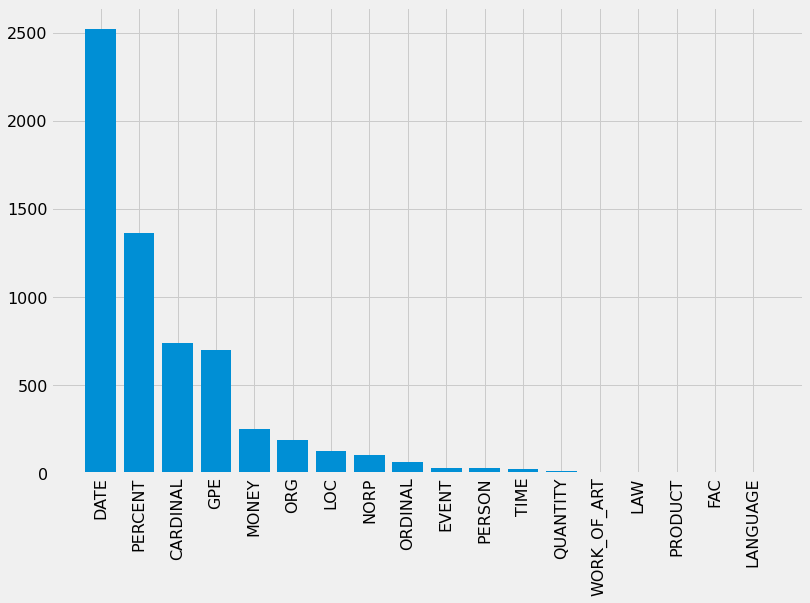

In [168]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.bar(
    height = clozes_df.answer_type.value_counts().values,
    x = clozes_df.answer_type.value_counts().keys().values)
# plt.hist(clozes_df.answer_type)
plt.xticks(rotation = 90)
plt.savefig(
    'images/distribution_of_answertypes.png',
    facecolor = 'white', bbox_inches = 'tight')
plt.show()

In [23]:
source_lengths = [len(x)for x in clozes_df.source_text]

lengths = pd.DataFrame({'lens': source_lengths, 'type': clozes_df.answer_type})

<AxesSubplot:ylabel='Frequency'>

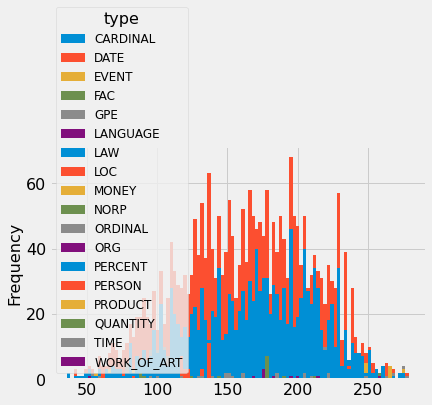

In [35]:
lengths.pivot(columns= 'type', values = 'lens').plot.hist(bins = 100)

In [37]:
clozes_df

,ids,cloze_text,source_text,answer_text,answer_type
0,ccf75a2c157eacc5253f0e8a55b1ded9f5386d58,"In TEMPORALMASK, approximate gross value added...","In 2019, approximate gross value added at basi...",2019,DATE
1,fc3346f2545ca5059bdb5150b998300c5001bea5,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...","£1,313.9 billion",MONEY
2,81aa32270d547a368e7b806646c72069ba4fac43,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",£42.8 billion,MONEY
3,f308eb661ad1d6c8021cf9e22d8e8c7d9c5ff50e,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",3.4%,PERCENT
4,0a0bcf4b990f1926bc87fa662badadaf7e23d5fa,"In 2019, approximate gross value added at basi...","In 2019, approximate gross value added at basi...",2018,DATE
...,...,...,...,...,...
6179,dce8c5e1d183452a3cc887d90ff0f64ef4bb82b5,Around 6 in 10 people (61%) reported feeling s...,Around 6 in 10 people (61%) reported feeling s...,76%,PERCENT
6180,e7c1fce9fcd8c918a07029ba4266c18391b1aa75,"In comparison, NUMERICMASK of people did not f...","In comparison, around 14% of people did not fe...",around 14%,PERCENT
6181,874948014cfa36eff9f493b57e8077f3bda23019,"In comparison, around 14% of people did not fe...","In comparison, around 14% of people did not fe...",38%,PERCENT
6182,fab3e03bd458df568f3d110940583bc1251dfd90,Some of the main UK findings (Source: IDENTITY...,Some of the main UK findings (Source: Understa...,Understanding Society,ORG


In [169]:
answers_text_type = clozes_df[['answer_text', 'answer_type']].value_counts()

In [214]:
# number of words in answer text
temp = clozes_df[['answer_text', 'answer_type']]
temp['answer_words'] = temp.answer_text.apply(lambda x: len(x.split(' ')))
temp.answer_words.describe()

<ipython-input-214-6ce5b25f82b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['answer_words'] = temp.answer_text.apply(lambda x: len(x.split(' ')))


count    6184.000000
mean        1.860446
std         1.353592
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: answer_words, dtype: float64

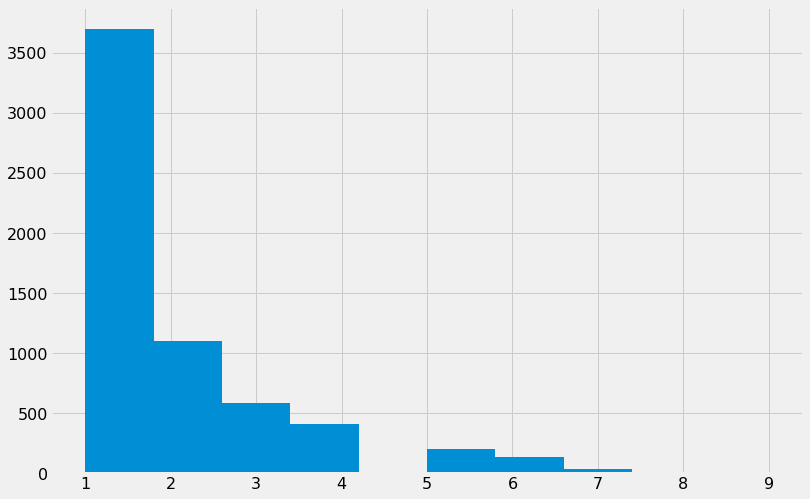

In [212]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.hist(temp.answer_words)

plt.savefig(
    'images/distribution_of_num_words_answer.png',
    facecolor = 'white', bbox_inches = 'tight')

plt.show()

In [240]:
subcats = []
subcat_dict = dict()
for k in df.sections:
    subcats.append(list(df.sections.get(k).keys()))
    subcat_dict[k] = list(df.sections.get(k).keys())
    
subcategories = [item for sub in subcats for item in sub]

In [239]:
len(subcategories)

31

In [244]:
for k in subcat_dict:
    print(f'category: {k}')
    print(f'subcat: {subcat_dict.get(k)}\n')

category: businessindustryandtrade
subcat: ['business', 'changestobusiness', 'constructionindustry', 'itandinternetindustry', 'internationaltrade', 'manufacturingandproductionindustry', 'retailindustry', 'tourismindustry']

category: economy
subcat: ['economicoutputandproductivity', 'environmentalaccounts', 'governmentpublicsectorandtaxes', 'grossdomesticproductgdp', 'grossvalueaddedgva', 'inflationandpriceindices', 'investmentspensionsandtrusts', 'nationalaccounts', 'regionalaccounts']

category: employmentandlabourmarket
subcat: ['peopleinwork', 'peoplenotinwork']

category: peoplepopulationandcommunity
subcat: ['birthsdeathsandmarriages', 'crimeandjustice', 'culturalidentity', 'educationandchildcare', 'elections', 'healthandsocialcare', 'householdcharacteristics', 'housing', 'leisureandtourism', 'personalandhouseholdfinances', 'populationandmigration', 'wellbeing']



In [245]:
subcat_dict.keys()

dict_keys(['businessindustryandtrade', 'economy', 'employmentandlabourmarket', 'peoplepopulationandcommunity'])